# ASL recognition

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
import matplotlib.pyplot as plt
import math
import time

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import plot_tree


In [2]:
def quality(Yp ,XT,YT):
    print('ACC: ' + format(accuracy_score(YT,Yp),".3f"))
    print('BAC: ' + format(balanced_accuracy_score(YT,Yp),".3f"))
    print('f1: ' + str(f1_score(YT, Yp, average='weighted')))
    print('CM:\n')
    plt.matshow(confusion_matrix(YT,Yp))

times = dict()

In [3]:
folder_path = "./training-a-robot-to-understand-sign-language/signlanguage/signlanguage/"
all_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg')) and not f.startswith('.')]
img_size=64

y = []
X_raw = np.empty((len(all_files), img_size*img_size), dtype=np.uint8)

for i, filename in enumerate(tqdm(all_files, desc="Elaborazione")):
    label = filename.split('_')[0]
    img_path = os.path.join(folder_path, filename)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))

    if img is None:
        print("Error reading image!")
        break
    X_raw[i] = img.flatten()
    y.append( label)
y = np.array(y)

Xl_raw, Xt_raw, yl_raw, yt_raw = train_test_split(X_raw/255, y, test_size=0.2, random_state=11)

Elaborazione: 100%|██████████| 8476/8476 [00:03<00:00, 2782.60it/s]


In [4]:
print(X_raw.shape)
print(y.shape)

(8476, 4096)
(8476,)


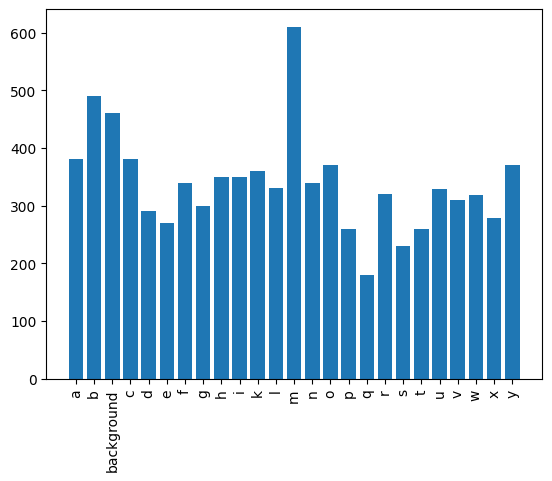

In [5]:
labels, count = np.unique(y, return_counts=True)
plt.bar(labels, count)
max_label_length = max([len(str(l)) for l in labels])

if max_label_length > 1:
    plt.xticks(rotation='vertical') 

plt.show()

C best: 1.0
ACC: 0.971
BAC: 0.975
f1: 0.9711305299734861
CM:



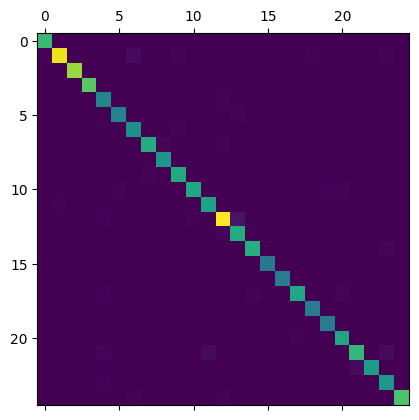

In [6]:
grid = {'C': np.logspace(-6,3,10)}
M_svc_raw = GridSearchCV(estimator  = LinearSVC(dual=False),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'f1_weighted',
                 n_jobs     = -2)

start_time = time.time()
M_svc_raw.fit(Xl_raw, yl_raw)
end_time = time.time() - start_time

Yp = M_svc_raw.predict(Xt_raw)

times["svc_raw"] = {
    "time": end_time,
    "f1": f1_score(yt_raw, Yp, average='weighted')
}
print('C best: ' + str(M_svc_raw.best_params_['C']))
quality(Yp,Xt_raw,yt_raw)

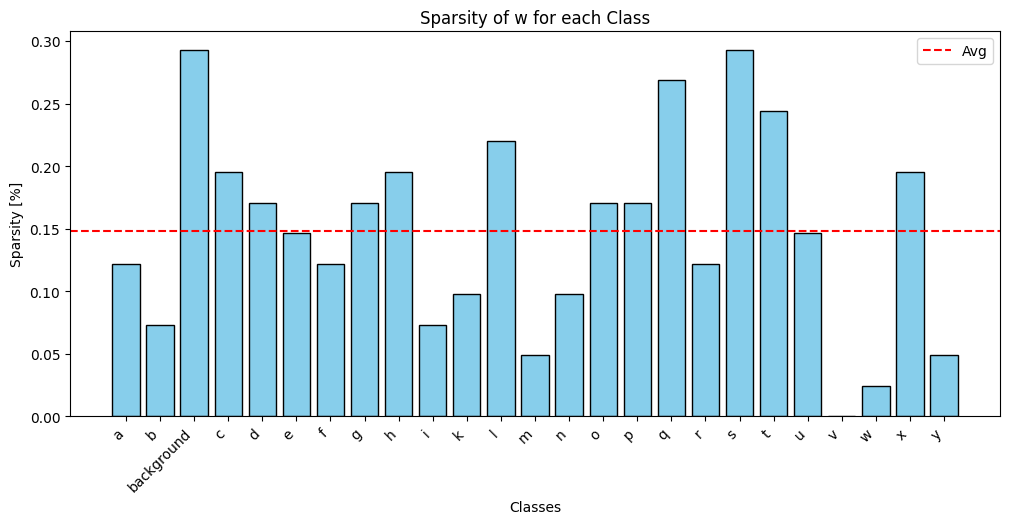

In [7]:
#Sparsity computation

threshold = 1e-4

best_model = M_svc_raw.best_estimator_
weights = best_model.coef_ 

for i, class_name in enumerate(best_model.classes_):
    n_zero = np.sum(np.abs(weights[i]) < threshold)
    sparsity = (n_zero / weights.shape[1]) * 100

sparsity_list = [np.mean(np.abs(weights[i]) < threshold) * 100 for i in range(len(weights))]

plt.figure(figsize=(12, 5))
plt.bar(best_model.classes_, sparsity_list, color='skyblue', edgecolor='black')
plt.axhline(y=np.mean(sparsity_list), color='r', linestyle='--', label='Avg')
plt.xticks(rotation=45, ha='right')

plt.title("Sparsity of w for each Class")
plt.ylabel("Sparsity [%]")
plt.xlabel("Classes")
plt.legend()
plt.show()

## Preprocessing

preprocessing is done using HOG and PCA

In [8]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def preprocess_image(img, ret_hog=False): 
    img = clahe.apply(img)

    # Estrazione HOG (orientations=9 è lo standard per i bordi)
    # Questo riduce l'immagine a un vettore di descrittori di forma
    return hog(img, orientations=9, pixels_per_cell=(8, 8),
               cells_per_block=(2, 2), visualize=ret_hog) 

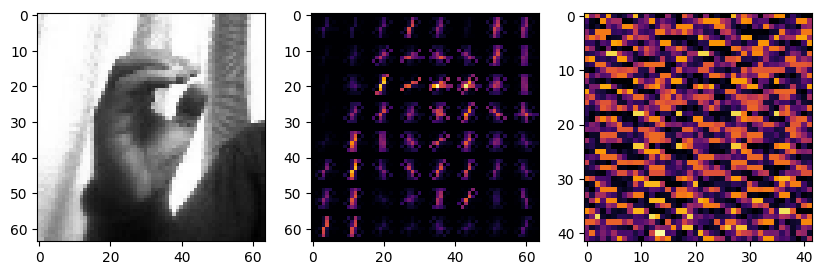

In [9]:
image = "c_1.png"

# 2. Caricamento e Preprocessing
img_path = os.path.join(folder_path, image)
img_raw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_raw = cv2.resize(img_raw, (img_size, img_size))

img, img_hog = preprocess_image(img_raw, ret_hog=True)

# print(f"label: {label}")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axs[0].imshow(img_raw, cmap='gray')
axs[1].imshow(img_hog, cmap='inferno')
axs[2].imshow(img.reshape(42,42), cmap='inferno')

scaler = StandardScaler()
img_scaled = scaler.fit_transform(img.reshape(1, -1))

In [10]:
X_hog = np.apply_along_axis(lambda x: preprocess_image(x.reshape(img_size, img_size)), 1, X_raw)
X_hog.shape

(8476, 1764)

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hog)

pca = PCA(n_components=0.95, random_state=42)
X = pca.fit_transform(X_scaled)

Xl, Xt, yl, yt = train_test_split(X, y, test_size=0.2, random_state=11)

print(f"Original features: {X_hog.shape[1]} -> Final features: {X.shape[1]}, kept {100*X.shape[1]/X_hog.shape[1]}% of features")

Original features: 1764 -> Final features: 453, kept 25.68027210884354% of features


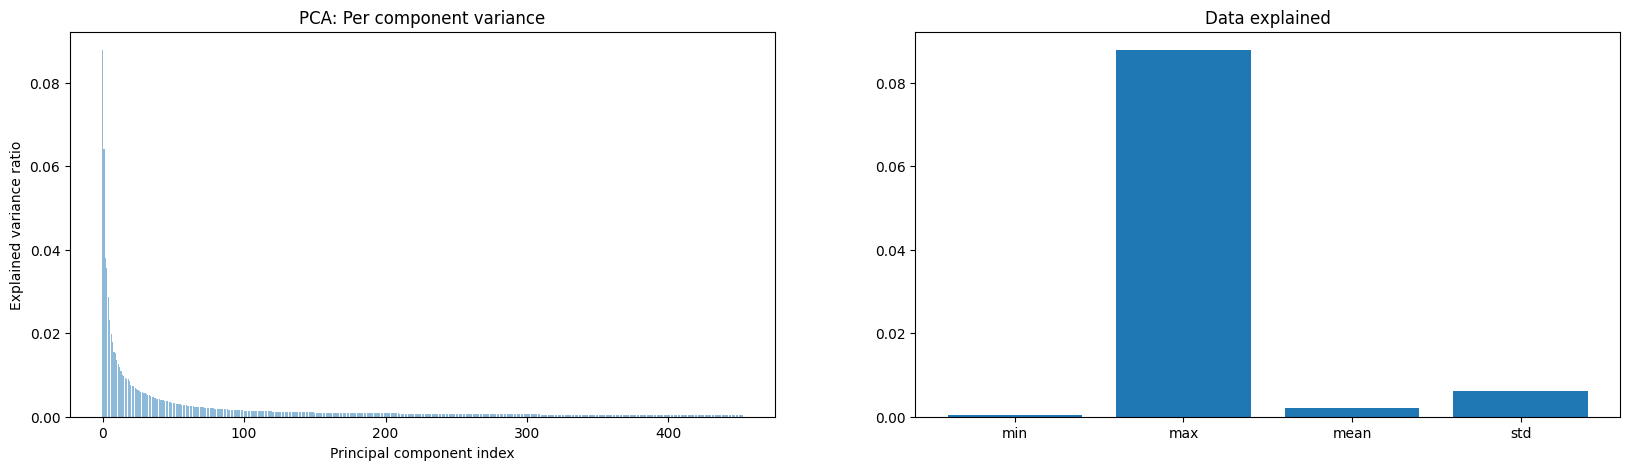

<Figure size 1000x600 with 0 Axes>

In [12]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

plt.figure(figsize=(10, 6))
axs[0].bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Varianza individuale')
axs[0].set_ylabel('Explained variance ratio')
axs[0].set_xlabel('Principal component index')
axs[0].set_title('PCA: Per component variance')

pcae = pca.explained_variance_ratio_
axs[1].set_title("Data explained")
axs[1].bar(["min", "max", "mean", "std"], [np.amin(pcae), np.amax(pcae), np.mean(pcae), np.std(pcae)])

plt.show()

## Models

C best: 0.1
ACC: 0.992
BAC: 0.993
f1: 0.9923453153249812
CM:



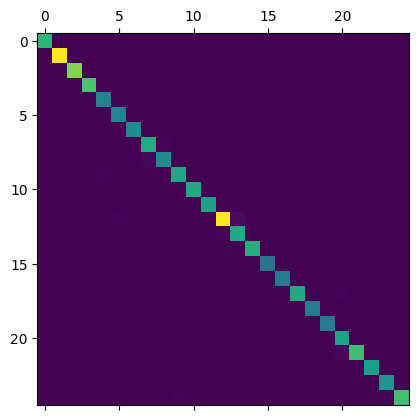

In [13]:
grid = {'C':                       np.logspace(-6,3,10),
        'kernel':                  ['linear'],
        'decision_function_shape': ['ovr']}
M_svc_lin = GridSearchCV(estimator  = SVC(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'f1_weighted',
                 n_jobs     = -2)

start_time = time.time()
M_svc_lin.fit(Xl, yl)
end_time = time.time() - start_time

Yp = M_svc_lin.predict(Xt)

times["svc_linear"] = {
    "time": end_time,
    "f1": f1_score(yt, Yp, average='weighted')
}
print('C best: ' + str(M_svc_lin.best_params_['C']))
quality(Yp,Xt,yt)


max_depth best: 40
ACC: 0.791
BAC: 0.789
f1: 0.7907067414926604
CM:



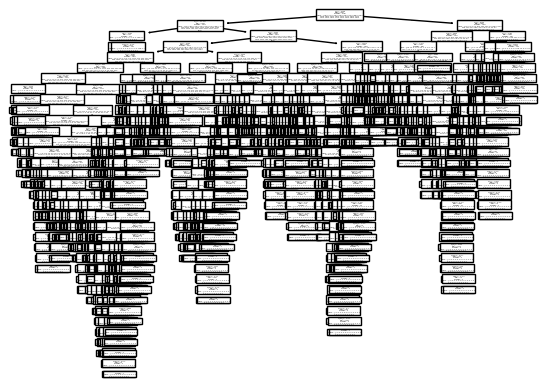

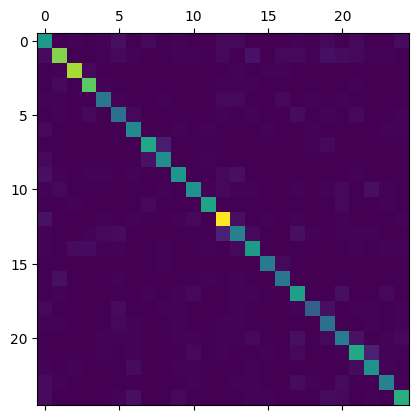

In [14]:
from sklearn.tree import DecisionTreeClassifier
grid = {'max_depth': [30,40,45,50, 60, 70]}
M_dec_tree = GridSearchCV(estimator  = DecisionTreeClassifier(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'f1_weighted',
                 n_jobs     = -2)

start_time = time.time()
M_dec_tree.fit(Xl,yl)
end_time = time.time() - start_time


print('max_depth best: ' + str(M_dec_tree.best_params_['max_depth']))
plot_tree(M_dec_tree.best_estimator_)


Yp = M_dec_tree.predict(Xt)

times["decision_tree_depth"] = {
    "time": end_time,
    "f1": f1_score(yt, Yp, average='weighted')
}

quality(Yp,Xt,yt)

min_samples_leaf best: 1
ACC: 0.783
BAC: 0.782
f1: 0.7835403798843495
CM:



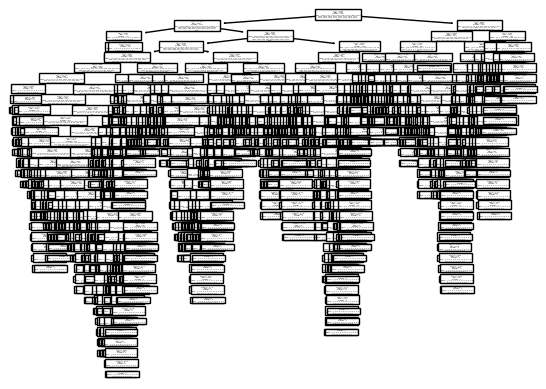

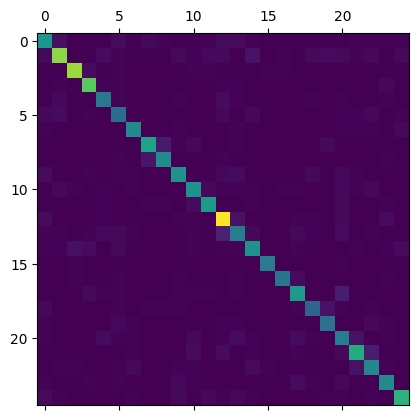

In [15]:
from sklearn.tree import DecisionTreeClassifier
grid = {'min_samples_leaf': [1,2,4,6,8,12,16,20,30]}
M_dec_tree_class = GridSearchCV(estimator  = DecisionTreeClassifier(),
                 param_grid = grid,
                 cv         = 3,
                 scoring    = 'f1_weighted',
                 n_jobs     = -2)
start_time = time.time()
M_dec_tree_class.fit(Xl,yl)
decision_tree_leaf_time = time.time() - start_time
print('min_samples_leaf best: ' + str(M_dec_tree_class.best_params_['min_samples_leaf']))
plot_tree(M_dec_tree_class.best_estimator_)



Yp = M_dec_tree_class.predict(Xt)

times["decision_tree_leaf"] = {
    "time": time.time() - start_time,
    "f1": f1_score(yt, Yp, average='weighted')
}

quality(Yp,Xt,yt)

ACC: 0.976
BAC: 0.978
f1: 0.97648898416127
CM:



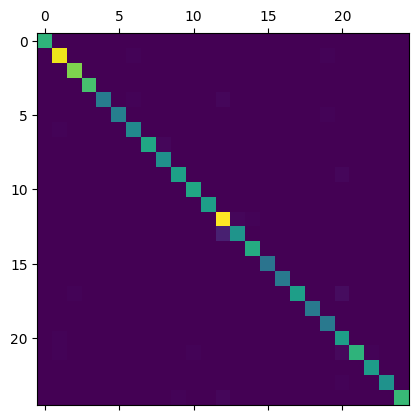

In [16]:
from sklearn.ensemble import RandomForestClassifier
M_rand_for = RandomForestClassifier(n_estimators=300)
start_time = time.time()
M_rand_for.fit(Xl,yl)
end_time = time.time() - start_time

Yp = M_rand_for.predict(Xt)

times["random_forest"] = {
    "time": end_time,
    "f1": f1_score(yt, Yp, average='weighted')
}

quality(Yp,Xt,yt)

n_estimators best: 300
max_features best: 28
ACC: 0.978
BAC: 0.979
f1: 0.9776785585415406
CM:



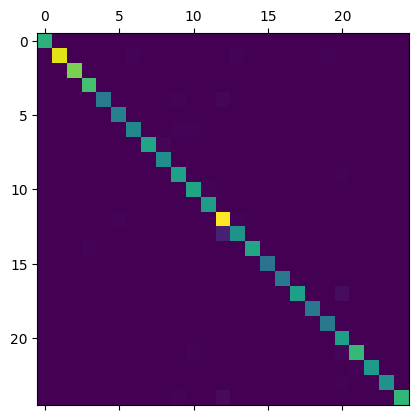

In [17]:
from sklearn.ensemble import RandomForestClassifier
grid = {'n_estimators': [300],
        'max_features': [10,16,20,28,32,40]}
M_rand_for_max = GridSearchCV(estimator  = RandomForestClassifier(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'f1_weighted',
                 n_jobs = -2)
start_time = time.time()
M_rand_for_max.fit(Xl,yl)
end_time = time.time() - start_time
print('n_estimators best: ' + str(M_rand_for_max.best_params_['n_estimators']))
print('max_features best: ' + str(M_rand_for_max.best_params_['max_features']))


Yp = M_rand_for_max.predict(Xt)

times["random_forest_grid"] = {
    "time": end_time,
    "f1": f1_score(yt, Yp, average='weighted')
}

quality(Yp,Xt,yt)

n_neighbors best: 1
ACC: 0.991
BAC: 0.991
f1: 0.9905928253682912
CM:



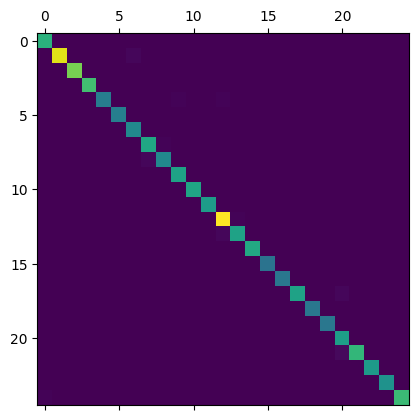

In [18]:
from sklearn.neighbors import KNeighborsClassifier
grid = {'n_neighbors':  [1,3,5,7,9,11,15,19]}
M_knn = GridSearchCV(estimator  = KNeighborsClassifier(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'f1_weighted')

start_time = time.time()
M_knn.fit(Xl,yl)
end_time = time.time() - start_time

print('n_neighbors best: ' + str(M_knn.best_params_['n_neighbors']))

Yp = M_knn.predict(Xt)

times["KNN"] = {
    "time": end_time,
    "f1": f1_score(yt, Yp, average='weighted')
}

quality(Yp,Xt,yt)

C best: 10.0
gamma best: 0.001
ACC: 0.992
BAC: 0.992
f1: 0.9917522842245414
CM:



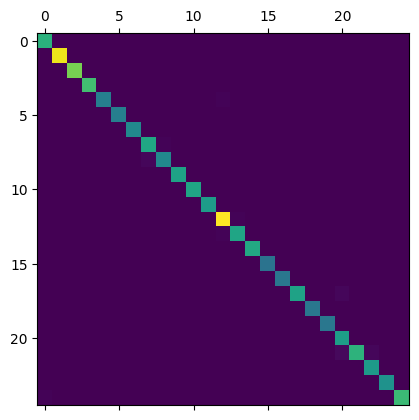

In [19]:
grid = {'C':                       np.logspace(-6,3,10),
        'kernel':                  ['rbf'],
        'gamma':                   np.logspace(-6,3,10),
        'decision_function_shape': ['ovr']}
M_svc_rbf = GridSearchCV(estimator  = SVC(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'f1_weighted',
                 n_jobs     = -2)
start_time = time.time()
M_svc_rbf.fit(Xl, yl)
end_time = time.time() - start_time

Yp = M_svc_rbf.predict(Xt)

times["svc_rbf"] = {
    "time": end_time,
    "f1": f1_score(yt, Yp, average='weighted')
}
print('C best: ' + str(M_svc_rbf.best_params_['C']))
print('gamma best: ' + str(M_svc_rbf.best_params_['gamma']))

quality(Yp,Xt,yt)

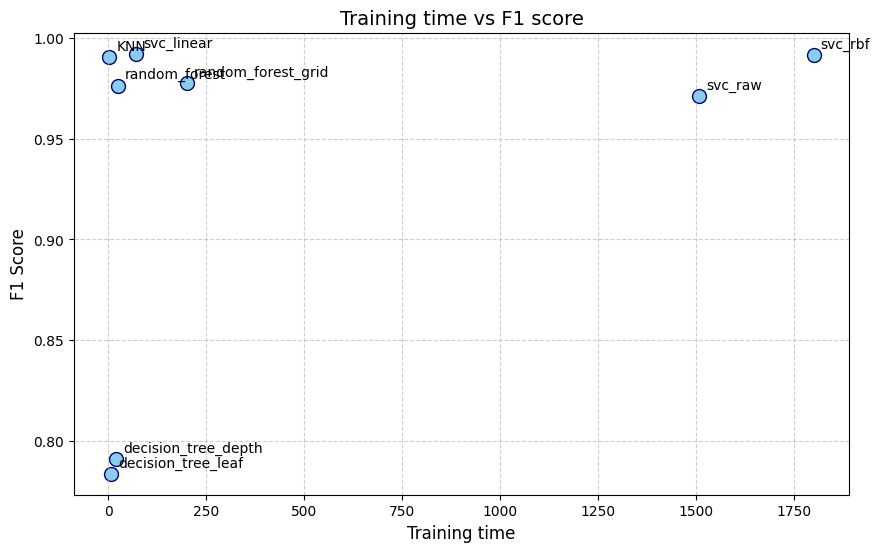

In [20]:
import matplotlib.pyplot as plt

labels = list(times.keys())
t = [v['time'] for v in times.values()]
f1_scores = [v['f1'] for v in times.values()]

plt.figure(figsize=(10, 6))
plt.scatter(t, f1_scores, color='skyblue', s=100, edgecolors='navy')

for i, label in enumerate(labels):
    plt.annotate(label, (t[i], f1_scores[i]), xytext=(5, 5), textcoords='offset points')

# Formattazione
plt.title('Training time vs F1 score', fontsize=14)
plt.xlabel('Training time', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()